In [31]:
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
from keras import backend as K

In [2]:
from keras.models import load_model
AM = load_model('face_gen.h5')

Using TensorFlow backend.
C:\Users\Konrad\Anaconda3\envs\tensor4\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
Gen = AM.get_layer("sequential_1")

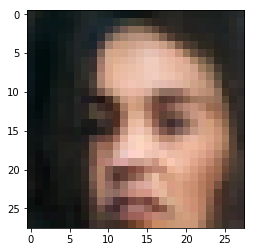

In [170]:
noise = K.random_uniform_variable((1,100), -1, 1)
i = Gen.predict(noise, steps=1)
im = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(im[0])

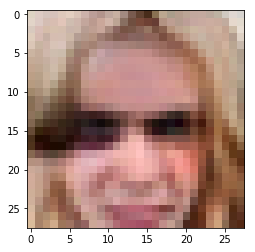

In [168]:
noise2 = K.random_uniform_variable((1,100), -1, 1)
i2 = Gen.predict(noise2, steps=1)
im2 = (((i2 - i2.min()) * 255) / (i2.max() - i2.min())).astype(np.uint8)
plt.imshow(im2[0])

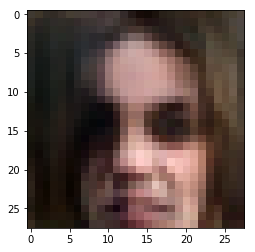

In [171]:
noise3 = (noise + noise2) / 2
i3 = Gen.predict(noise3, steps=1)
im3 = (((i3 - i3.min()) * 255) / (i3.max() - i3.min())).astype(np.uint8)
plt.imshow(im3[0])

In [127]:
Gen.outputs[0]

<tf.Tensor 'activation_1/Tanh:0' shape=(?, ?, ?, 3) dtype=float32>

Step: 0
Step: 5
Step: 10
Step: 15
Step: 20
Step: 25
Step: 30
Step: 35
Step: 40
Step: 45
Step: 50
Step: 55
Step: 60
Step: 65
Step: 70
Step: 75
Step: 80
Step: 85
Step: 90
Step: 95


C:\Users\Konrad\Anaconda3\envs\tensor4\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


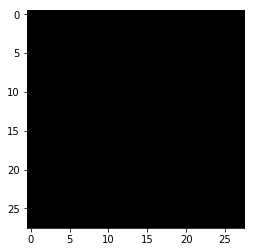

In [102]:
z = K.random_uniform_variable((1,100), -1, 1)

x = K.placeholder()
loss = K.sum(K.square(x - Gen.outputs[0]))
grad = K.gradients(loss, Gen.inputs[0])[0]
update_fn = K.function(Gen.inputs + [x], [grad])

for step in range(100):
    j = Gen.predict(z, steps=1)
    #for _ in range(5):
    update_vec = update_fn([z, im])[0]
    z -= update_vec * 0.1
    
    if step % 5 == 0:
        print("Step:", step)

j = Gen.predict(z, steps=1)
j = (((j - j.min()) * 255) / (j.max() - j.min())).astype(np.uint8)
plt.imshow(j[0])

In [74]:
Gen.inputs

[<tf.Tensor 'dense_1_input:0' shape=(?, 100) dtype=float32>]